Episode 0 : -39938.37474822998
Episode 1 : -29885.22834777832
Episode 2 : -49923.52468729019
Episode 3 : -19788.532676696777
Episode 4 : -29926.178829193115
Episode 5 : -39863.097933769226
Episode 6 : -39908.97351646423
Episode 7 : -39927.06160545349
Episode 8 : -49808.70809555054
Episode 9 : -29838.768810272217
Episode 10 : -49943.450087070465
Episode 11 : -29890.717586517334
Episode 12 : -19785.366662740707
Episode 13 : -29897.120412826538
Episode 14 : -49776.11491012573
Episode 15 : -39834.35775470734
Episode 16 : -19857.249541282654
Episode 17 : -39935.64626407623
Episode 18 : -29881.0945892334
Episode 19 : -19852.85383248329
Episode 20 : -39905.380491256714
Episode 21 : -29824.555270195007
Episode 22 : -29903.778559684753
Episode 23 : -19858.982669353485
Episode 24 : -39881.43629169464
Episode 25 : -19840.99298620224
Episode 26 : -39959.5940656662
Episode 27 : -49794.07370185852
Episode 28 : -49766.70815658569
Episode 29 : -29856.239623069763
Episode 30 : -29885.12864971161
Episod

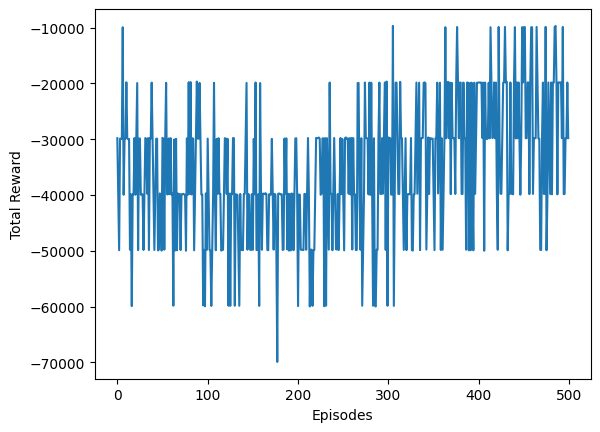

In [3]:
# Modified_tsp.py (Environment Code)

"""Environment for Modified Travelling Salesman Problem."""

from typing import Dict, List, Optional, Tuple
import gymnasium as gym
import numpy as np
from numpy import typing as npt


class ModTSP(gym.Env):
    """Travelling Salesman Problem (TSP) RL environment for maximizing profits.

    The agent navigates a set of targets based on precomputed distances. It aims to visit
    all targets so maximize profits. The profits decay with time.
    """

    def __init__(
        self,
        num_targets: int = 10,
        max_area: int = 15,
        shuffle_time: int = 10,
        seed: int = 42,
    ) -> None:
        """Initialize the TSP environment.

        Args:
            num_targets (int): No. of targets the agent needs to visit.
            max_area (int): Max. Square area where the targets are defined.
            shuffle_time (int): No. of episodes after which the profits ar to be shuffled.
            seed (int): Random seed for reproducibility.
        """
        super().__init__()

        np.random.seed(seed)

        self.steps: int = 0
        self.episodes: int = 0

        self.shuffle_time: int = shuffle_time
        self.num_targets: int = num_targets

        self.max_steps: int = num_targets
        self.max_area: int = max_area

        self.locations: npt.NDArray[np.float32] = self._generate_points(self.num_targets)
        self.distances: npt.NDArray[np.float32] = self._calculate_distances(self.locations)

        # Initialize profits for each target
        self.initial_profits: npt.NDArray[np.float32] = np.arange(1, self.num_targets + 1, dtype=np.float32) * 10.0
        self.current_profits: npt.NDArray[np.float32] = self.initial_profits.copy()

        # Observation Space : {current loc (loc), target flag - visited or not, current profits, dist_array (distances), coordintates (locations)}
        self.obs_low = np.concatenate(
            [
                np.array([0], dtype=np.float32),  # Current location
                np.zeros(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                np.zeros(self.num_targets, dtype=np.float32),  # Array of all current profits values
                np.zeros(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                np.zeros(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        self.obs_high = np.concatenate(
            [
                np.array([self.num_targets], dtype=np.float32),  # Current location
                np.ones(self.num_targets, dtype=np.float32),  # Check if targets were visited or not
                100 * np.ones(self.num_targets, dtype=np.float32),  # Array of all current profits values
                2 * self.max_area * np.ones(self.num_targets, dtype=np.float32),  # Distance to each target from current location
                self.max_area * np.ones(2 * self.num_targets, dtype=np.float32),  # Cooridinates of all targets
            ]
        )

        # Action Space : {next_target}
        self.observation_space = gym.spaces.Box(low=self.obs_low, high=self.obs_high)
        self.action_space = gym.spaces.Discrete(self.num_targets)

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ) -> Tuple[np.ndarray, Dict[str, None]]:
        """Reset the environment to the initial state.

        Args:
            seed (Optional[int], optional): Seed to reset the environment. Defaults to None.
            options (Optional[dict], optional): Additional reset options. Defaults to None.

        Returns:
            Tuple[np.ndarray, Dict[str, None]]: The initial state of the environment and an empty info dictionary.
        """
        self.steps: int = 0
        self.episodes += 1

        self.loc: int = 0
        self.visited_targets: npt.NDArray[np.float32] = np.zeros(self.num_targets)
        self.current_profits = self.initial_profits.copy()
        self.dist: List = self.distances[self.loc]

        if self.shuffle_time % self.episodes == 0:
            np.random.shuffle(self.initial_profits)

        state = np.concatenate(
            (
                np.array([self.loc]),
                self.visited_targets,
                self.initial_profits,
                np.array(self.dist),
                np.array(self.locations).reshape(-1),
            ),
            dtype=np.float32,
        )
        return state, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
        """Take an action (move to the next target).

        Args:
            action (int): The index of the next target to move to.

        Returns:
            Tuple[np.ndarray, float, bool, bool, Dict[str, None]]:
                - The new state of the environment.
                - The reward for the action.
                - A boolean indicating whether the episode has terminated.
                - A boolean indicating if the episode is truncated.
                - An empty info dictionary.
        """
        self.steps += 1
        past_loc = self.loc
        next_loc = action

        self.current_profits -= self.distances[past_loc, next_loc]
        reward = self._get_rewards(next_loc)

        self.visited_targets[next_loc] = 1

        next_dist = self.distances[next_loc]
        terminated = bool(self.steps == self.max_steps)
        truncated = False

        next_state = np.concatenate(
            [
                np.array([next_loc]),
                self.visited_targets,
                self.current_profits,
                next_dist,
                np.array(self.locations).reshape(-1),
            ],
            dtype=np.float32,
        )

        self.loc, self.dist = next_loc, next_dist
        return (next_state, reward, terminated, truncated, {})

    def _generate_points(self, num_points: int) -> npt.NDArray[np.float32]:
        """Generate random 2D points representing target locations.

        Args:
            num_points (int): Number of points to generate.

        Returns:
            np.ndarray: Array of 2D coordinates for each target.
        """
        return np.random.uniform(low=0, high=self.max_area, size=(num_points, 2)).astype(np.float32)

    def _calculate_distances(self, locations: npt.NDArray[np.float32]) -> npt.NDArray[np.float32]:
        """Calculate the distance matrix between all target locations.

        Args:
            locations: List of 2D target locations.

        Returns:
            np.ndarray: Matrix of pairwise distances between targets.
        """
        n = len(locations)

        distances = np.zeros((n, n), dtype=np.float32)
        for i in range(n):
            for j in range(n):
                distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        return distances

    def _get_rewards(self, next_loc: int) -> float:
        """Calculate the reward based on the distance traveled, however if a target gets visited again then it incurs a high penalty.

        Args:
            next_loc (int): Next location of the agent.

        Returns:
            float: Reward based on the travel distance between past and next locations, or negative reward if repeats visit.
        """
        reward = self.current_profits[next_loc] if not self.visited_targets[next_loc] else -1e4
        return float(reward)


def main() -> None:
    """Main function."""
    num_targets = 10

    env = ModTSP(num_targets)
    obs = env.reset()
    ep_rets = []

    for ep in range(10000):
        ret = 0
        obs = env.reset()
        for _ in range(10000):
            action = env.action_space.sample()  # You need to replace this with your algorithm that predicts the action.

            obs_, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ret += reward

            if done:
                break

        ep_rets.append(ret)
        print(f"Episode {ep} : {ret}")

    print(np.mean(ep_rets))


if __name__ == "__main__":
    main()


# Q-learning Integration

import matplotlib.pyplot as plt
from collections import defaultdict

# Initialize environment
env = ModTSP(num_targets=10, shuffle_time=10, seed=42)

# Q-learning parameters
alpha = 0.1         # Learning rate
gamma = 0.9         # Discount factor
epsilon = 1.0       # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.1
episodes = 500   # Number of training episodes

# Discretize state space by defining bins for each feature
bins = 10  # Number of bins for discretization
state_bins = [np.linspace(low, high, bins) for low, high in zip(env.obs_low, env.obs_high)]

# Function to discretize the continuous state into a discrete one
def discretize_state(state):
    state_idx = tuple(np.digitize(s, state_bins[i]) - 1 for i, s in enumerate(state))
    return state_idx

# Initialize Q-table
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

# Store rewards for plotting
rewards = []

for episode in range(episodes):
    state, _ = env.reset()
    state = discretize_state(state)

    total_reward = 0
    terminated = False

    while not terminated:
        # Choose action: Exploit vs. Explore
        if np.random.random() < epsilon:
            action = env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(q_table[state])  # Exploit: best action based on Q-table

        # Take action and observe the new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Update Q-value using the Bellman equation
        best_future_q = np.max(q_table[next_state])
        q_table[state][action] += alpha * (reward + gamma * best_future_q - q_table[state][action])

        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

# Plotting the rewards over episodes
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
#plt.title('Q-learning on Modified TSP')
plt.show()


Episode: 1, Total Reward: -49940.0
Episode: 2, Total Reward: -29920.0
Episode: 3, Total Reward: -19910.0
Episode: 4, Total Reward: -39930.0
Episode: 5, Total Reward: -29920.0
Episode: 6, Total Reward: -39930.0
Episode: 7, Total Reward: -39930.0
Episode: 8, Total Reward: -39930.0
Episode: 9, Total Reward: -29920.0
Episode: 10, Total Reward: -19910.0
Episode: 11, Total Reward: -29920.0
Episode: 12, Total Reward: -49940.0
Episode: 13, Total Reward: -39930.0
Episode: 14, Total Reward: -39930.0
Episode: 15, Total Reward: -19910.0
Episode: 16, Total Reward: -49940.0
Episode: 17, Total Reward: -39930.0
Episode: 18, Total Reward: -39930.0
Episode: 19, Total Reward: -49940.0
Episode: 20, Total Reward: -39930.0
Episode: 21, Total Reward: -29920.0
Episode: 22, Total Reward: -29920.0
Episode: 23, Total Reward: -39930.0
Episode: 24, Total Reward: -39930.0
Episode: 25, Total Reward: -39930.0
Episode: 26, Total Reward: -19910.0
Episode: 27, Total Reward: -39930.0
Episode: 28, Total Reward: -49940.0
E

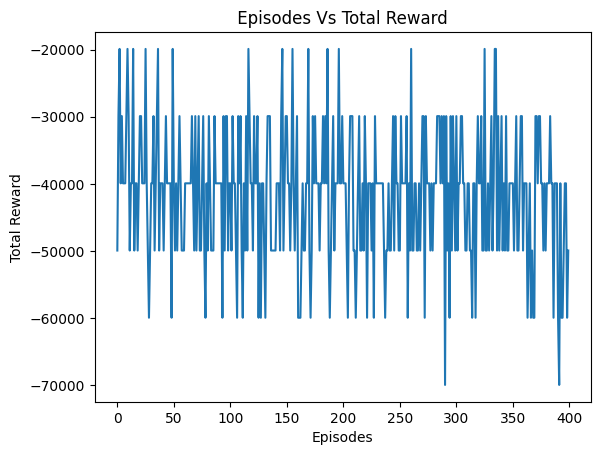

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym
from gymnasium import spaces

class ModTSP(gym.Env):
    def __init__(self, num_targets=10, shuffle_time=10, seed=42):
        super(ModTSP, self).__init__()
        np.random.seed(seed)
        self.num_targets = num_targets
        self.shuffle_time = shuffle_time
        self.seed(seed)
        
        # Define observation space (positions of the agent)
        self.obs_low = np.zeros(num_targets)  # minimum possible state values
        self.obs_high = np.ones(num_targets) * 10  # maximum possible state values
        
        self.observation_space = spaces.Box(low=self.obs_low, high=self.obs_high, dtype=np.float32)
        
        # Define action space: The actions could be moving to one of the targets.
        self.action_space = spaces.Discrete(num_targets)
        
        # Placeholder for the agent's position and target status
        self.agent_pos = 0
        self.target_status = [False] * num_targets
        self.time = 0
        
        # Internal variables to track the total number of steps
        self.total_steps = 0
        
    def seed(self, seed=None):
        np.random.seed(seed)
    
    def reset(self):
        self.agent_pos = 0
        self.target_status = [False] * self.num_targets
        self.time = 0
        self.total_steps = 0
        
        # Return the initial observation
        return self._get_observation(), {}
    
    def _get_observation(self):
        # Observations could include the agent's position and the targets visited.
        observation = np.zeros(self.num_targets)
        observation[self.agent_pos] = 1  # One-hot encoding of agent's position
        return observation
    
    def step(self, action):
        # The action corresponds to moving to a specific target
        self.agent_pos = action
        
        # Check if the target has already been visited
        if not self.target_status[self.agent_pos]:
            reward = 10  # Reward for visiting a new target
            self.target_status[self.agent_pos] = True
        else:
            reward = -1e4  # Penalty for revisiting the same target
        
        self.time += 1
        self.total_steps += 1
        
        # If all targets are visited or time exceeds limit, terminate the episode
        terminated = all(self.target_status) or self.time > self.shuffle_time
        
        truncated = False  # You can handle episode truncation based on other factors if needed
        
        return self._get_observation(), reward, terminated, truncated, {}
    
    def render(self):
        # Optional: Render the environment for visualization
        pass

# Initialize environment
env = ModTSP(num_targets=10, shuffle_time=10, seed=42)

# Q-learning parameters
alpha = 0.01        # Learning rate
gamma = 0.95        # Discount factor
epsilon = 1.0       # Exploration rate
epsilon_decay = 0.9995  # Slower decay
epsilon_min = 0.05  # Ensure sufficient exploration
episodes = 400    # Number of training episodes
bins = 10           # Discretization bins for each state variable

# Discretize state space by defining bins for each feature
state_bins = [np.linspace(low, high, bins) for low, high in zip(env.obs_low, env.obs_high)]

# Function to discretize continuous state into discrete one
def discretize_state(state):
    state_idx = tuple(np.digitize(s, state_bins[i]) - 1 for i, s in enumerate(state))
    return state_idx

# Initialize Q-table
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

# Store rewards for plotting
rewards = []

for episode in range(episodes):
    state, _ = env.reset()
    state = discretize_state(state)
    total_reward = 0
    terminated = False

    while not terminated:
        # Choose action: Exploit vs. Explore
        if np.random.random() < epsilon:
            action = env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(q_table[state])  # Exploit: best action based on Q-table

        # Take action and observe the new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Update Q-value using Bellman equation
        best_future_q = np.max(q_table[next_state])
        q_table[state][action] += alpha * (reward + gamma * best_future_q - q_table[state][action])

        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)
    print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

# Plotting the rewards over episodes
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title(' Episodes Vs Total Reward ')
plt.show()


Episode: 1000, Total Reward: -14
Episode: 2000, Total Reward: -6
Episode: 3000, Total Reward: -7
Episode: 4000, Total Reward: -328
Episode: 5000, Total Reward: -46
Episode: 6000, Total Reward: -8
Episode: 7000, Total Reward: -129
Episode: 8000, Total Reward: -45
Episode: 9000, Total Reward: -46
Episode: 10000, Total Reward: -131
Episode: 11000, Total Reward: -11
Episode: 12000, Total Reward: -27
Episode: 13000, Total Reward: -10
Episode: 14000, Total Reward: -191
Episode: 15000, Total Reward: -2
Episode: 16000, Total Reward: -10
Episode: 17000, Total Reward: -26
Episode: 18000, Total Reward: -9
Episode: 19000, Total Reward: -86
Episode: 20000, Total Reward: -7
Episode: 21000, Total Reward: -68
Episode: 22000, Total Reward: -8
Episode: 23000, Total Reward: -20
Episode: 24000, Total Reward: -59
Episode: 25000, Total Reward: -45
Episode: 26000, Total Reward: -3
Episode: 27000, Total Reward: -51
Episode: 28000, Total Reward: -44
Episode: 29000, Total Reward: -7
Episode: 30000, Total Reward

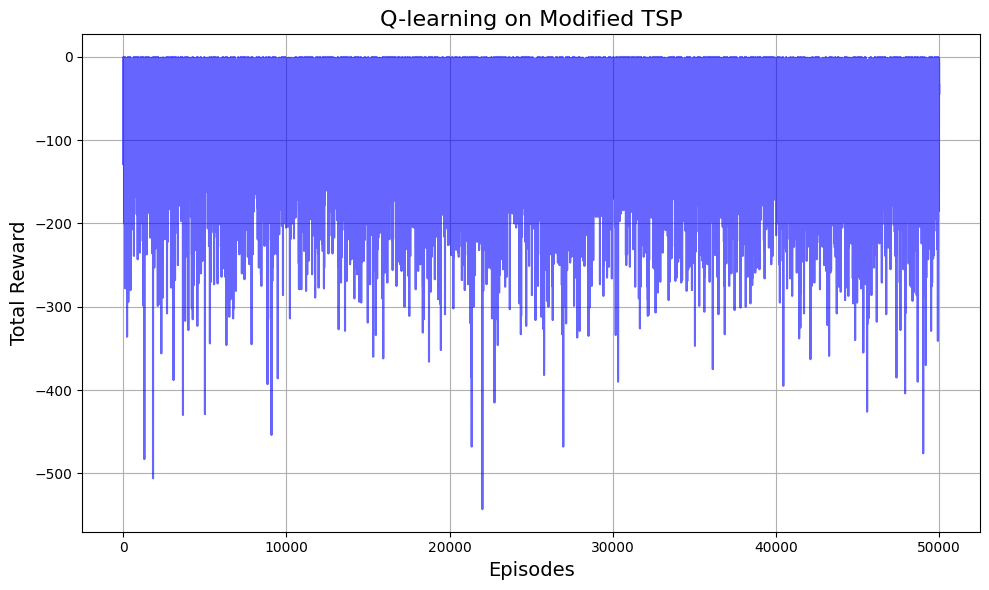

In [3]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import gymnasium as gym

# Custom TSP Environment (assuming you have it correctly defined in the file or using an external library)
class ModTSP:
    def __init__(self, num_targets, shuffle_time, seed=42):
        self.num_targets = num_targets
        self.shuffle_time = shuffle_time
        self.seed = seed
        np.random.seed(seed)
        self.action_space = gym.spaces.Discrete(num_targets)
        self.obs_low = [0] * num_targets
        self.obs_high = [100] * num_targets

    def reset(self):
        self.state = np.random.uniform(low=self.obs_low, high=self.obs_high, size=(self.num_targets,))
        return self.state, {}

    def step(self, action):
        reward = np.random.randint(-10, 1)  # Random reward for now, adjust as per your logic
        terminated = np.random.random() < 0.1  # Random termination condition for demonstration
        truncated = False
        next_state = np.random.uniform(low=self.obs_low, high=self.obs_high, size=(self.num_targets,))
        return next_state, reward, terminated, truncated, {}

    def render(self):
        pass

# Initialize environment
env = ModTSP(num_targets=10, shuffle_time=10, seed=42)

# Q-learning parameters
alpha = 0.1         # Learning rate
gamma = 0.9         # Discount factor
epsilon = 1.0       # Exploration rate
epsilon_decay = 0.999  # Slower decay for better exploration
epsilon_min = 0.1
episodes = 50000     # Reduce episodes to see results faster

# Discretize state space by defining bins for each feature
bins = 15  # Increased the number of bins to improve discretization
state_bins = [np.linspace(low, high, bins) for low, high in zip(env.obs_low, env.obs_high)]

# Function to discretize the continuous state into a discrete one
def discretize_state(state):
    state_idx = tuple(np.digitize(s, state_bins[i]) - 1 for i, s in enumerate(state))
    return state_idx

# Initialize Q-table
q_table = defaultdict(lambda: np.zeros(env.action_space.n))

# Store rewards for plotting
rewards = []

# Function to plot rewards
def plot_rewards(rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, color='blue', alpha=0.6)
    plt.xlabel('Episodes', fontsize=14)
    plt.ylabel('Total Reward', fontsize=14)
    plt.title('Q-learning on Modified TSP', fontsize=16)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Q-learning loop
for episode in range(episodes):
    state, _ = env.reset()
    state = discretize_state(state)

    total_reward = 0
    terminated = False

    while not terminated:
        # Choose action: Exploit vs. Explore
        if np.random.random() < epsilon:
            action = env.action_space.sample()  # Explore: random action
        else:
            action = np.argmax(q_table[state])  # Exploit: best action based on Q-table

        # Take action and observe the new state and reward
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_state(next_state)

        # Update Q-value using the Bellman equation
        best_future_q = np.max(q_table[next_state])
        q_table[state][action] += alpha * (reward + gamma * best_future_q - q_table[state][action])

        state = next_state
        total_reward += reward

        if terminated or truncated:
            break

    # Decay epsilon after each episode
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    rewards.append(total_reward)
    
    # Print every 1000 episodes to reduce output clutter
    if (episode + 1) % 1000 == 0:
        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

# Plot rewards over episodes
plot_rewards(rewards)
